# Notebook Preamble

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard libraries
import logging
import os
import pathlib
import sys

# 3rd party libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy as sa

# Local libraries
import pudl

In [3]:
sns.set()
%matplotlib inline
mpl.rcParams['figure.figsize'] = (10,4)
mpl.rcParams['figure.dpi'] = 100
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [4]:
logger=logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

# Function Definitions

## `prep_gens()`

In [5]:
def prep_gens(pudl_out, prime_mover_codes):
    """
    Preproccessing function to look at generators by prime mover and year.
    """
    gens_eia860 = pudl_out.gens_eia860()
    # Generator selection criteria
    working_gens = gens_eia860.loc[gens_eia860.prime_mover_code.isin(prime_mover_codes)]
    # Calculate the annual generation by generator
    net_gen_by_gen = (
        pudl_out.gen_eia923()
        .set_index("report_date")
        .groupby([pd.Grouper(freq="AS"), "plant_id_eia", "generator_id"])
        .net_generation_mwh.sum()
        .to_frame()
        .reset_index()
    )
    # Merge annual generation by generator into the working DF
    return pd.merge(
        working_gens,
        net_gen_by_gen,
        how="left",
        validate="1:1",
    )

## `unit_gen_coverage()`

In [6]:
def unit_gen_coverage(prepped_gens):
    """
    Characterize generator-level PUDL Unit ID coverage by year.
    
    For each year and fossil fuel prime mover code, calculate:
    
    * number & fraction of generator_id values that have a unit_id_pudl
    * sum and fraction of overall capacity (MW) that has a unit_id_pudl
    * sum and fraction of overall generation (MWh) associated with a
      unit_id_pudl in the generation_eia923 table
    
    """
    working_gens = prepped_gens.copy()
    # A boolean column indicating whether a record has a PUDL Unit ID
    working_gens.loc[:, "has_unit_id"] = working_gens.unit_id_pudl.notna()
    
    def tot_frac(df, col):
        return df.loc[:, (col, True)] / df[col].sum(axis="columns")
    
    working_gens = (
        working_gens.groupby(["report_date", "prime_mover_code", "has_unit_id"])
        .agg(
            num_gens=pd.NamedAgg(column="generator_id", aggfunc="size"),
            capacity_mw=pd.NamedAgg(column="capacity_mw", aggfunc="sum"),
            net_generation_mwh=pd.NamedAgg(column="net_generation_mwh", aggfunc="sum"),
        )
        .unstack(fill_value=0)
        .assign(
            num_gens_fraction=lambda x: tot_frac(x, "num_gens"),
            capacity_mw_fraction=lambda x: tot_frac(x, "capacity_mw"),
            net_generation_mwh_fraction=lambda x: tot_frac(x, "net_generation_mwh"),
        )
    )
    return working_gens

## `chp_prevalence()`

In [7]:
def chp_prevalence(gens_df):
    """
    Assess the prevalence of Combined Heat & Power in Generators.
    
    Break down generators by year and prime mover, and within each group
    calculate the proportion and total quantity associated with CHP per
    
    * number of generators
    * capacity (MW)
    * generation (MWh) in the generation_eia923 table
    """
    gens_working = gens_df.copy()
    # A boolean column indicating whether a record is associated with CHP
    gens_working.loc[:, "ass_chap"] = gens_working.associated_combined_heat_power.astype(bool)
    
    def tot_frac(df, col):
        return df.loc[:, (col, True)] / df[col].sum(axis="columns")
    
    gens_working = (
        gens_working.groupby(["report_date", "prime_mover_code", "ass_chap"])
        .agg(
            num_gens=pd.NamedAgg(column="generator_id", aggfunc="size"),
            capacity_mw=pd.NamedAgg(column="capacity_mw", aggfunc="sum"),
            net_generation_mwh=pd.NamedAgg(column="net_generation_mwh", aggfunc="sum"),
        )
        .unstack(fill_value=0)
        .assign(
            num_gens_fraction=lambda x: tot_frac(x, "num_gens"),
            capacity_mw_fraction=lambda x: tot_frac(x, "capacity_mw"),
            net_generation_mwh_fraction=lambda x: tot_frac(x, "net_generation_mwh"),
        )
    )
    return gens_working 

## `fill_unit_ids()`

In [8]:
def fill_unit_ids(gens):
    """
    Back and forward fill Unit IDs for each plant / gen combination.
    
    This routine assumes that the mapping of generators to units is constant
    over time, and extends those mappings into years where no boilers have
    been reported -- since in the BGA we can only connect generators to each
    other if they are both connected to a boiler.
    
    Prior to 2014, combined cycle units didn't report any "boilers" but in
    latter years, they have been given "boilers" that correspond to their
    generators, so that all of their fuel consumption is recorded alongside
    that of other types of generators.
    
    Returns:
        pd.DataFrame: with columns: report_date, plant_id_eia, generator_id,
            unit_id_pudl, prime_mover_code, unit_id_source, unit_id_new
    """
    # forward and backward fill the unit IDs
    gen_ids = ["plant_id_eia", "generator_id"]
    gens = gens.sort_values(["report_date", "plant_id_eia", "generator_id"])

    bfill_units = gens.groupby(gen_ids)["unit_id_pudl"].bfill()
    bfill_idx = (bfill_units.notnull()) & (gens.unit_id_pudl.isnull())
    gens.loc[bfill_idx, "bga_source"] = "bfill_units"
    gens.loc[bfill_idx, "unit_id_pudl"] = bfill_units.loc[bfill_idx]
    
    ffill_units = gens.groupby(gen_ids)["unit_id_pudl"].ffill()
    ffill_idx = (ffill_units.notnull()) & (gens.unit_id_pudl.isnull())
    gens.loc[ffill_idx, "bga_source"] = "ffill_units"
    gens.loc[ffill_idx, "unit_id_pudl"] = ffill_units.loc[ffill_idx]
    gens["bga_source"] = gens["bga_source"].astype(pd.StringDtype())

    return gens

## `test_gen_units_are_unique()`
Add this to the integration tests

In [9]:
def test_generator_consistency(df, col):
    """
    Test that every generator is associated with at most one value of col.
    
    Does not treat NA values of ``col`` as separate values (they are ignored).
    
    Args:
        df (pandas.DataFrame): A dataframe containing columns
            ``plant_id_eia``, ``generator_id``, and ``col``.

    Returns:
        None

    """
    gens_with_col = df[["plant_id_eia", "generator_id", col]].dropna().drop_duplicates()
    unique_gens = gens_with_col[["plant_id_eia", "generator_id"]].drop_duplicates()
    pd.testing.assert_frame_equal(
        gens_with_col[["plant_id_eia", "generator_id"]],
        unique_gens[["plant_id_eia", "generator_id"]],
    )

## `test_inconsistent_gen_ids()`
Add this to the integration tests.

In [10]:
def test_inconsistent_gen_ids(pudl_out):
    """
    Find generator IDs that only differ by case and non-alphanumeric characters.
    """
    gens_eia860 = pudl_out.gens_eia860()
    clean_gen_ids = (
        gens_eia860[["plant_id_eia", "generator_id"]].drop_duplicates()
        .assign(
            clean_gen_id=lambda x: x.generator_id.str.upper().str.replace(r"[^a-zA-Z0-9]", ""),
        )
    )

    dirty_gen_ids = (
        clean_gen_ids.drop_duplicates(subset=["plant_id_eia", "clean_gen_id"], keep=False)
    )
    inconsistent_gen_ids = (
        clean_gen_ids[clean_gen_ids.duplicated(subset=["plant_id_eia", "clean_gen_id"], keep=False)]
        .sort_values(["plant_id_eia", "clean_gen_id"])
    )
    logger.info("Found %s inconsistently reported generator_id values.", len(inconsistent_gen_ids))
    
    if len(inconsistent_gen_ids) > 40:
        raise AssertionError
    
    return inconsistent_gen_ids

## `max_unit_id_by_plant()`

In [11]:
def max_unit_id_by_plant(gens_df):
    """
    Identify the largest unit ID associated with each plant so we don't overlap.
    
    This calculation depends on having all of the generators and units of all
    kinds still available in the dataframe!
    """
    return (
        gens_df[["plant_id_eia", "unit_id_pudl"]]
        .drop_duplicates()
        .groupby("plant_id_eia").agg({"unit_id_pudl": max})
        .fillna(0)
        .rename(columns={"unit_id_pudl": "max_unit_id_pudl"})
        .reset_index()
    )

## `assign_simple_unit_ids()`

In [12]:
def assign_simple_unit_ids(gens_df, prime_mover_codes, label_prefix="single"):
    """
    Assign unique PUDL Unit IDs to all generators of a given prime mover type.

    Calculate the maximum pre-existing PUDL Unit ID within each plant, and
    assign each as of yet unidentified distinct generator within each plant
    with an incrementing integer unit_id_pudl, beginning with 1 + the previous
    maximum unit_id_pudl found in that plant. Mark that generator with the
    given label.

    Only generators with an NA unit_id_pudl will be assigned a new ID
    
    Args:
        gens_df (pandas.DataFrame): A collection of EIA generator records.
            Must include the ``plant_id_eia``, ``generator_id`` and
            ``prime_mover_code`` and ``unit_id_pudl`` columns.
        prime_mover_codes (list): List of prime mover codes for which we are
            attempting to assign simple Unit IDs.
        label_prefix (str): String to use in labeling records as to how their
            unit_id_pudl was set. Will be concatenated with the prime mover
            code.
        
    Returns:
        pandas.DataFrame: A new dataframe with the same rows and columns as
        were passed in, but with the unit_id_pudl and bga_source columns updated
        to reflect the newly assigned Unit IDs.

    """

    # Only alter the rows lacking Unit IDs and matching our target prime movers
    row_mask = (gens_df.prime_mover_code.isin(prime_mover_codes)) & (gens_df.unit_id_pudl.isnull())
    # We only need a few columns to make these assignments.
    cols = ["plant_id_eia", "generator_id", "unit_id_pudl", "prime_mover_code"]
    
    logger.info(
        "Selected %s %s records lacking Unit IDs from %s records overall. ",
        len(row_mask[row_mask==True]), prime_mover_codes, len(gens_df)
    )

    unit_ids = (
        gens_df.loc[row_mask, cols]
        .drop_duplicates()
        .merge(
            max_unit_id_by_plant(gens_df),
            on="plant_id_eia",
            how="left",
            validate="many_to_one",
        )
        # Assign new unit_id_pudl values based on number of distinct generators:
        .assign(
            unit_id_pudl=lambda x: x.groupby("plant_id_eia").cumcount() + x.max_unit_id_pudl + 1,
            bga_source=lambda x: label_prefix + "_" + x.prime_mover_code.str.lower(),
        )
        .drop(["max_unit_id_pudl", "prime_mover_code"], axis="columns")
    )
    # Split original dataframe based on row_mask, and merge in the new IDs and
    # labels only on the subset of the dataframe matching our row_mask:
    out_df = gens_df.loc[~row_mask].append(
        gens_df.loc[row_mask]
        .drop(["unit_id_pudl", "bga_source"], axis="columns")
        .merge(
            unit_ids,
            on=["plant_id_eia", "generator_id"],
            how="left",
            validate="many_to_one",
        )
    )
        
    return out_df


## `assign_unique_combined_cycle_unit_ids()`

In [13]:
def assign_unique_combined_cycle_unit_ids(gens_df):
    """
    Assign unit IDs to combined cycle plants with a unique CT or CA generator.
    
    Within each plant, for any generator that has no Unit ID, count the number
    of generators of each prime mover type. Assign any collection of generators
    having only a single CT or a single CA a unit ID, and flag it "unique_cc".
    Assign collection of generators having multiple CTs and multiple CAs unit
    IDs and flag them "multi_cc"
    """
    
    pm_cols = ["plant_id_eia", "generator_id", "prime_mover_code"]
    # Get rid of the annual dependence, and only keep gens with missing PMs
    df = gens_df[gens_df.unit_id_pudl.isna()][pm_cols].drop_duplicates()
    # Count up the number of each kind of prime mover on a per-plant ID basis:
    pm_counts = (
        df.groupby(["plant_id_eia", "prime_mover_code"])
        .size()
        .unstack(fill_value=0)
    )
    # Plant IDs with at least one CT and one CA
    # and either a single CA or a single CT.
    # This makes the combined cycle unit grouping unambiguous.
    cc_plant_ids = pm_counts[
        (pm_counts["CA"] > 0)
        & (pm_counts["CT"] > 0)
        & ((pm_counts["CT"] == 1) | (pm_counts["CA"] == 1))
    ].index
    row_mask = (
        gens_df.plant_id_eia.isin(cc_plant_ids)
        & gens_df.unit_id_pudl.isnull()
        & gens_df.prime_mover_code.isin(["CA", "CT"])
    )

    # Create Unit IDs for CA/CT generators that are being grouped together.
    # Note that generator_id is not involved here because all of the
    # selected generators within each plant are going to get the same Unit ID
    unit_ids = (
        gens_df.loc[row_mask, ["plant_id_eia", "unit_id_pudl"]]
        .drop_duplicates()
        .merge(
            max_unit_id_by_plant(gens_df),
            on="plant_id_eia",
            how="left",
            validate="many_to_one",
        )
        # Assign new unit_id_pudl values by incrementing beyond the previous max
        .assign(
            unit_id_pudl=lambda x: x.max_unit_id_pudl + 1,
            bga_source=lambda x: "agg_unique_cc",
        )
        .drop("max_unit_id_pudl", axis="columns")
    )

    out_df = gens_df.loc[~row_mask].append(
        gens_df.loc[row_mask]
        .drop(["unit_id_pudl", "bga_source"], axis="columns")
        .merge(
            unit_ids,
            on="plant_id_eia",
            how="left",
            validate="many_to_one",
        )
    )
    return out_df

## `assign_complex_combined_cycle_unit_ids()`

In [14]:
def assign_complex_combined_cycle_unit_ids(gens_df):
    """
    Assign unit IDs to combined cycle plants that must aggregate CT/CA PMs
    """
    
    pm_cols = ["plant_id_eia", "generator_id", "prime_mover_code"]
    # Get rid of the annual dependence, and only keep gens with missing PMs
    df = gens_df[gens_df.unit_id_pudl.isna()][pm_cols].drop_duplicates()
    # Plant IDs with more than one CT and more than one CA
    cc_plant_ids = (
        df.groupby(["plant_id_eia", "prime_mover_code"])
        .size()
        .unstack(fill_value=0)
        .query("CA > 1 & CT > 1")
    ).index
    row_mask = (
        gens_df.plant_id_eia.isin(cc_plant_ids)
        & gens_df.unit_id_pudl.isnull()
        & gens_df.prime_mover_code.isin(["CA", "CT"])
    )

    # Create Unit IDs for CA/CT generators that are being grouped together.
    # Note that generator_id is not involved here because all of the
    # selected generators within each plant are going to get the same Unit ID
    unit_ids = (
        gens_df.loc[row_mask, ["plant_id_eia", "unit_id_pudl"]]
        .drop_duplicates()
        .merge(
            max_unit_id_by_plant(gens_df),
            on="plant_id_eia",
            how="left",
            validate="many_to_one",
        )
        # Assign new unit_id_pudl values by incrementing beyond the previous max
        .assign(
            unit_id_pudl=lambda x: x.max_unit_id_pudl + 1,
            bga_source=lambda x: "agg_complex_cc",
        )
        .drop("max_unit_id_pudl", axis="columns")
    )

    out_df = gens_df.loc[~row_mask].append(
        gens_df.loc[row_mask]
        .drop(["unit_id_pudl", "bga_source"], axis="columns")
        .merge(
            unit_ids,
            on="plant_id_eia",
            how="left",
            validate="many_to_one",
        )
    )
    return out_df

## `flag_orphan_combined_cycle_gens()`

In [15]:
def flag_orphan_combined_cycle_gens(gens_df, orphan_code):
    """
    Flag CA/CT generators without corresponding CT/CAs as orphans.
    
    Args:
        gens_df (pandas.DataFrame): Must contain the columns plant_id_eia,
            generator_id, and prime mover code. The column bga_code will
            be created or assigned in matching rows 
        orphan_code (str): Prime mover code indicating which type of generator
            is being flagged as orphaned. Must be either "CA" or "CT".
    
    Returns:
        pandas.DataFrame
    
    Raises:
        ValueError: if orphan_code is not CA or CT.

    """
    if orphan_code == "CA":
        missing_code = "CT"
    elif orphan_code == "CT":
        missing_code = "CA"
    else:
        raise ValueError(f"orphan must be either 'CA' or 'CT', but we got {orphan}.")

    orphan_plant_ids = (
        gens_df[gens_df.unit_id_pudl.isnull()]
        .drop_duplicates(subset=["plant_id_eia", "generator_id", "prime_mover_code"])
        .groupby(["plant_id_eia", "prime_mover_code"])
        .size()
        .unstack(fill_value=0)
        .query(f"{orphan_code} > 0 & {missing_code} == 0")
    ).index
    row_mask = (
        (gens_df.plant_id_eia.isin(orphan_plant_ids))
        & (gens_df.unit_id_pudl.isnull())
        & (gens_df.prime_mover_code == orphan_code)
    )
    out_df = gens_df.loc[~row_mask].append(
        gens_df.loc[row_mask]
        .assign(bga_source=f"orphan_{orphan_code.lower()}")
    )
    return out_df

## `plot_unit_ids()`

In [16]:
def plot_unit_ids(df, pm_codes):
    for code in pm_codes:
        data = (
            df[df.prime_mover_code==code]
            .groupby("report_date")["unit_id_pudl"]
            .count()
        )
        plt.plot(data, label=code, linewidth="2", markersize="4", marker="o")
    plt.legend(loc="upper left")
    plt.ylabel("Generator Records with Unit IDs")
    plt.show();

# Pull data & set constants

## Notebook Constants

In [17]:
THERMAL_PRIME_MOVERS = [ "CT", "CS", "CA", "CC", "GT", "IC", "ST", ]

GENS_COLS = [
    "report_date",
    "plant_id_eia",
    "plant_name_eia",
    "unit_id_pudl",
    "bga_source",
    "generator_id",
    "capacity_mw",
    "prime_mover_code",
    "energy_source_code_1",
    "energy_source_code_2",
    "fuel_type_code_pudl",
    "technology_description",
    "associated_combined_heat_power",
]


## Create PUDL output object

In [18]:
pudl_settings = pudl.workspace.setup.get_defaults()
display(pudl_settings)

ferc1_engine = sa.create_engine(pudl_settings['ferc1_db'])
pudl_engine = sa.create_engine(pudl_settings['pudl_db'])

API_KEY_EIA = os.environ["API_KEY_EIA"]

pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine)

{'pudl_in': '/home/zane/code/catalyst/pudl-work',
 'data_dir': '/home/zane/code/catalyst/pudl-work/data',
 'settings_dir': '/home/zane/code/catalyst/pudl-work/settings',
 'pudl_out': '/home/zane/code/catalyst/pudl-work',
 'sqlite_dir': '/home/zane/code/catalyst/pudl-work/sqlite',
 'parquet_dir': '/home/zane/code/catalyst/pudl-work/parquet',
 'datapkg_dir': '/home/zane/code/catalyst/pudl-work/datapkg',
 'ferc1_db': 'sqlite:////home/zane/code/catalyst/pudl-work/sqlite/ferc1.sqlite',
 'pudl_db': 'sqlite:////home/zane/code/catalyst/pudl-work/sqlite/pudl.sqlite',
 'censusdp1tract_db': 'sqlite:////home/zane/code/catalyst/pudl-work/sqlite/censusdp1tract.sqlite'}

# Improve PUDL Unit ID Coverage
* Initially, most generators are not part of generation units, as defined by the boiler generator association (BGA)
* To implement a uniform heat rate calculation process, we need unit IDs that indicate which aggregations of generation and fuel consumption should be considered together.
* This section applies several different methods to expand the number of fossil fuel generators that are part of generation units.
* Most of these methods depend on the prime mover and in some case fuel type associated with the generator.
* Prime mover and fuel type are available both in the generator and the generation_fuel tables.

## Pull the original generator data and simplify
* For the moment we are starting with the full catalog of generator attributes.
* We need access to some of the data fields (prime mover, fuel type, technology type...)
* However, the Unit ID assignment process is really producing entity-level connections.
* So far as I can tell, the Unit ID values should be constant across all years.

In [19]:
%%time
gens1 = pudl_out.gens_eia860()[GENS_COLS]
test_generator_consistency(gens1, "unit_id_pudl")
test_generator_consistency(gens1, "prime_mover_code")

CPU times: user 43.8 s, sys: 5.13 s, total: 48.9 s
Wall time: 49.3 s


## Fill in missing BGA units
* Many cases in which generation units didn't report completely (esp. before 2014)
* However, often the boiler & generator IDs and associations appear to be the same.
* We can back/forward fill the boiler IDs prior to the BGA process, and get consistent units across all years.
* Can also back/forward fill boiler IDs and unit IDs after the fact and *should* get the same result.
* This will address many currently "boilerless" CCNG units which have use generator ID as boiler ID in latter years.
* We could try and apply this more generally, but in the cases of generator IDs that haven't been used as boiler IDs, it would break the FK relationship with the boiler table, unless we added them there too, which seems like a lot of muddling

In [20]:
%%time
gens2 = fill_unit_ids(gens1)
assert gens1.shape == gens2.shape
test_generator_consistency(gens2, "unit_id_pudl")
test_generator_consistency(gens2, "prime_mover_code")

CPU times: user 1.23 s, sys: 3.75 ms, total: 1.23 s
Wall time: 1.24 s


## Simple Units
* Any single-shaft Combined Cycle generator (CS -- always single-gen)
  * There are a few hundred of these w/o unit_id_pudl values.
  * Each one corresponds to a single unique (plant_id_eia, generator_id).
* Any whole Combined Cycle generator (CC -- always single-gen)
  * These are "generators" for which the combustion & steam turbines co-report.
* Gas Turbines (GT)
* Internal Combustion Engines (IC)

In [21]:
%%time
simple_pm_codes = ["CC", "CS", "GT", "IC"]
gens3 = assign_simple_unit_ids(gens2, prime_mover_codes=simple_pm_codes)
assert gens2.shape == gens3.shape
test_generator_consistency(gens3, "unit_id_pudl")
test_generator_consistency(gens3, "prime_mover_code")

Selected 172517 ['CC', 'CS', 'GT', 'IC'] records lacking Unit IDs from 403832 records overall. 
CPU times: user 1.84 s, sys: 334 µs, total: 1.85 s
Wall time: 1.88 s


## Aggregated Unique Combined Cycle Units
* For any plant that contains both CA and CT generators,
* and **only** has a signle CA **or** a single CT,
* all the CA and CT generators must be part of the same unit.

In [22]:
%%time
gens4 = assign_unique_combined_cycle_unit_ids(gens3)
assert gens3.shape == gens4.shape
test_generator_consistency(gens4, "unit_id_pudl")
test_generator_consistency(gens4, "prime_mover_code")

CPU times: user 1.41 s, sys: 868 µs, total: 1.41 s
Wall time: 1.41 s


## Aggregated Complex Combined Cycle Units
* For any plant that contains more than one CA and more than one CT,
* we cannot distinguish which ones are connected to each other,
* thus they must all be aggregated into a single unit.

In [23]:
%time
gens5 = assign_complex_combined_cycle_unit_ids(gens4)
assert gens4.shape == gens5.shape
test_generator_consistency(gens5, "unit_id_pudl")
test_generator_consistency(gens5, "prime_mover_code")

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.53 µs


## Orphaned Combined Cycle Generators
* In some plants there are **only** CA or CT generators, but not both.
* Can this arrangement actually be valid? Or does it mean that some generators are mislabeled ST and GT?
* How can we identify ST and GT generators that are actually part of combined cycle units?

In [24]:
%%time
gens6 = (
    gens5.pipe(flag_orphan_combined_cycle_gens, orphan_code="CA")
    .pipe(flag_orphan_combined_cycle_gens, orphan_code="CT")
)
assert gens5.shape == gens6.shape
test_generator_consistency(gens6, "unit_id_pudl")
test_generator_consistency(gens6, "prime_mover_code")

CPU times: user 2.19 s, sys: 4.1 ms, total: 2.2 s
Wall time: 2.19 s


## Explore pre-existing unit structure
* How are steam turbines of a given fuel type typically arranged in generation units?
* How many generators share a unit ID with each ST generator?
* How does this vary depending on primary fuel type (gas vs. coal vs. nuclear, etc.)?
* Count the number of generators in each unit, and merge that back onto the dataframe.
* Select records from the result based on fuel_type_code_pudl and prime_mover_code and make histograms.

In [25]:
gens_with_units = (
    gens1.dropna(subset=["unit_id_pudl"])
    .drop_duplicates(subset=["plant_id_eia", "generator_id"])
    .loc[:, ["plant_id_eia", "unit_id_pudl", "generator_id", "prime_mover_code", "fuel_type_code_pudl"]]
)

unit_gen_count = gens_with_units.merge(
    gens_with_units
    .groupby(["plant_id_eia", "unit_id_pudl"])["generator_id"].count()
    .rename("unit_gen_count")
    .reset_index(),
    on=["plant_id_eia", "unit_id_pudl"],
    how="left",
    validate="many_to_one"
)

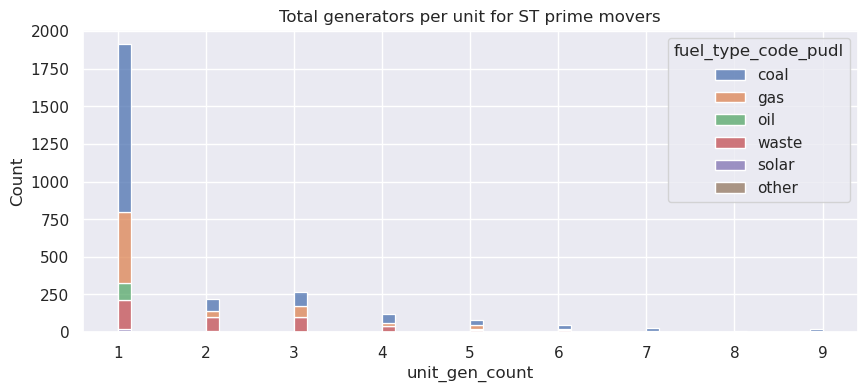

In [26]:
pmc = 'ST'
steam_gen_counts =  unit_gen_count.query("prime_mover_code==@pmc")
sns.histplot(x="unit_gen_count", hue="fuel_type_code_pudl", data=steam_gen_counts, multiple="stack")
plt.title(f"Total generators per unit for {pmc} prime movers");

## Assign Steam Turbine Unit IDs
* The above suggests that steam turbine (ST) generators are not typically connected to other generators in a more complex generation unit, at least in the case of coal and gas fired turbines, which make up a large majority of the generators.
* For the time being, assign them unique per-generator Unit IDs. We'll see whether this results in ridiculous heat rates later on, and potentially re-organize.

In [27]:
%%time
gens7 = assign_simple_unit_ids(gens6, prime_mover_codes=["ST"])
assert gens7.shape == gens6.shape
test_generator_consistency(gens7, "unit_id_pudl")
test_generator_consistency(gens7, "prime_mover_code")

Selected 19689 ['ST'] records lacking Unit IDs from 403832 records overall. 
CPU times: user 1.38 s, sys: 3.56 ms, total: 1.38 s
Wall time: 1.39 s


## Assign Unit IDs to orphan CA / CT generators
* We can do this safely now only because we know all non-orphan CA/CT generators have already been assigned unit IDs above.

In [28]:
%%time
gens8 = assign_simple_unit_ids(gens7, prime_mover_codes=["CT", "CA"], label_prefix="orphan")
assert gens8.shape == gens7.shape
test_generator_consistency(gens8, "unit_id_pudl")
test_generator_consistency(gens8, "prime_mover_code")

Selected 1169 ['CT', 'CA'] records lacking Unit IDs from 403832 records overall. 
CPU times: user 1.54 s, sys: 678 µs, total: 1.54 s
Wall time: 1.54 s


## Notes on Unit ID Assignment
* What is the output table describing these units going to look like?
* Should it be several different well normalized tables defining different kinds of Unit IDs?
* Should it be a single un-normalized table?
* Should we backfill the technology description to older years?
* Should we fill in pseudo-boiler IDs for the units that we've created, like the latter years of CCNG plants do?

# Assess Unit ID Coverage

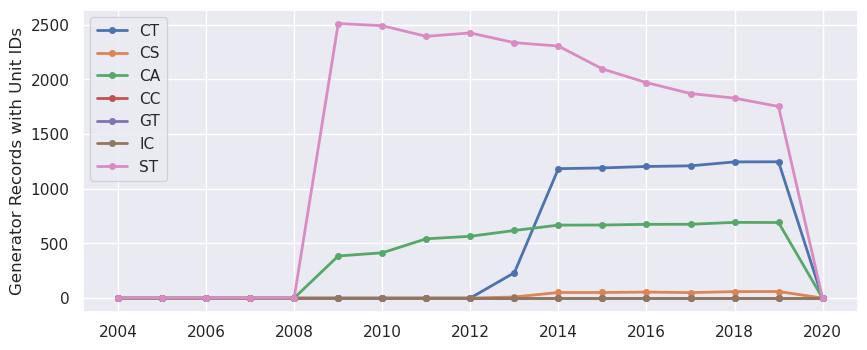

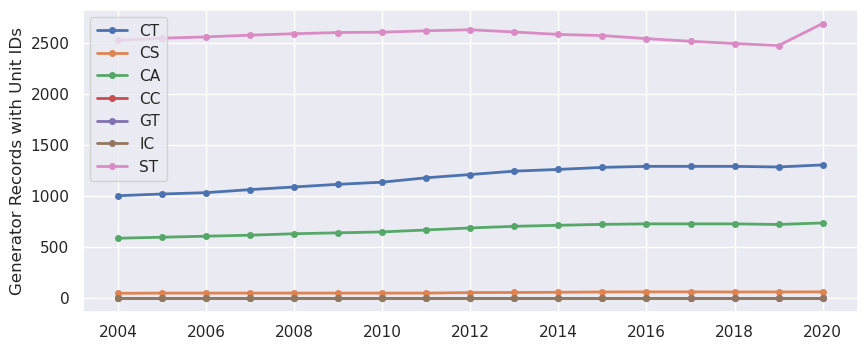

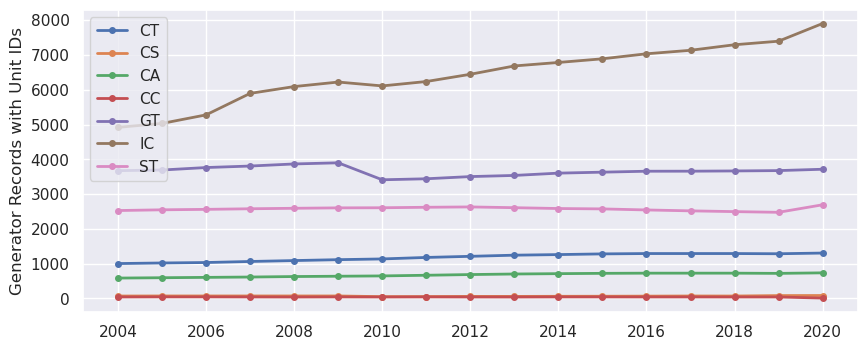

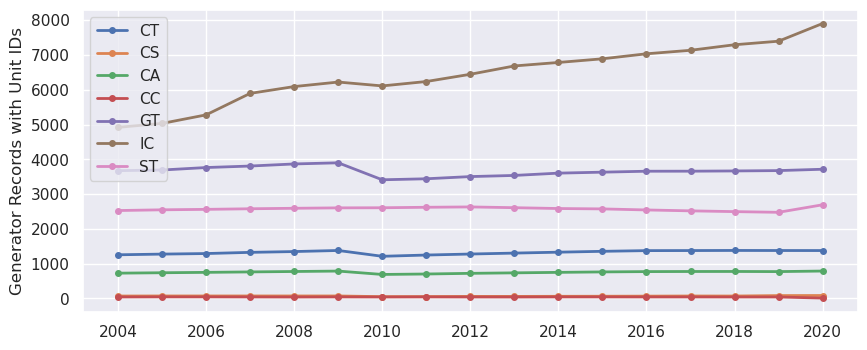

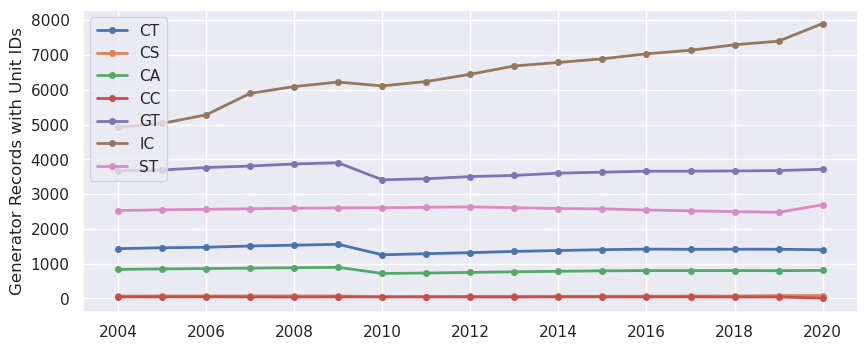

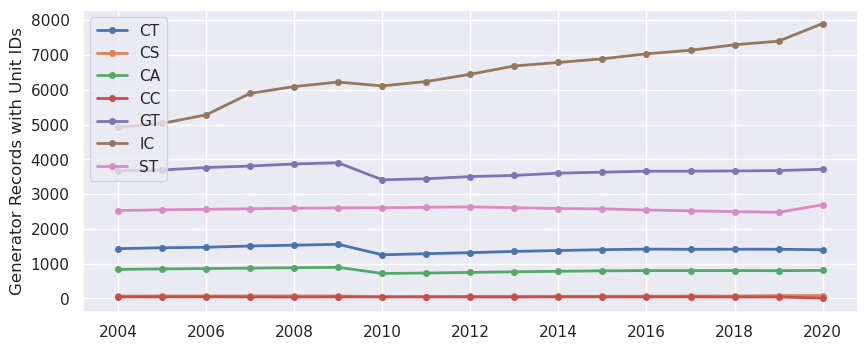

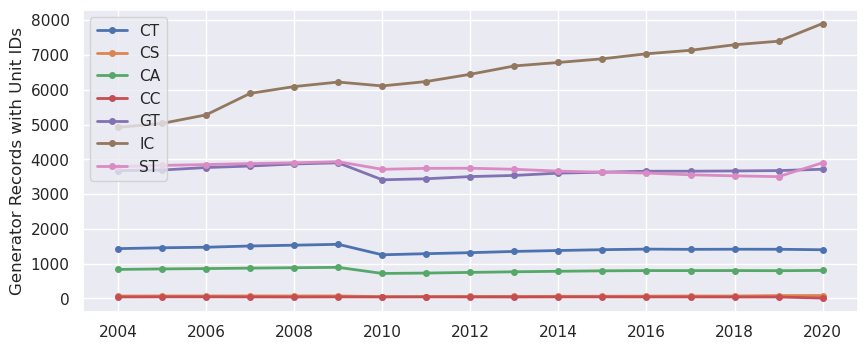

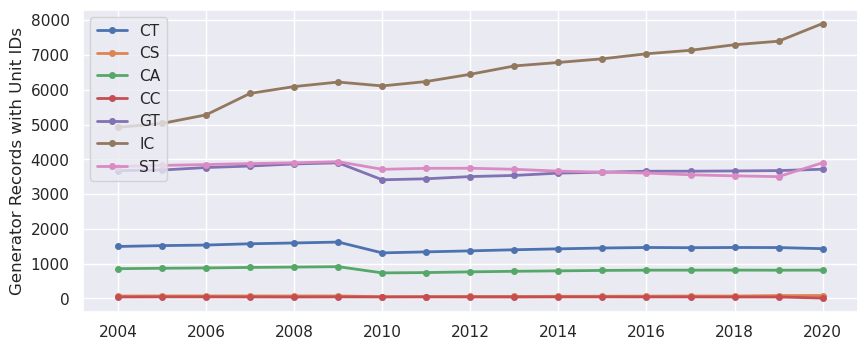

In [29]:
for df in [gens1, gens2, gens3, gens4, gens5, gens6, gens7, gens8]:
    plot_unit_ids(df, THERMAL_PRIME_MOVERS)

## Examine Existing Unit ID Coverage
Only a fraction of all fossil generation is associated with PUDL Unit IDs, which are integral to our most granular heat rate determination. We need to understand how good the coverage is, and why the generators / generation we're missing isn't covered. THere's at least 3 ways we can evaluate this coverage, at the generator level, based on information in the `generators_eia860` table:
* by generator ID
* by capacity (MW)
* by generation (MWh)

These can be broken down by:
* Time (look at annual quantities and how they've changed)
* Prime mover code (useful since it's in both generation and generation_fuel tables)
* Whether the generators appear in the `generation_eia923` table
* Whether the generators are associated with CHP
  * Are there plants where all generators do CHP? Would be useful for benchmarking heat rate impacts.
* Primary fuel (not totally well defined, since there are many mixed-fuel generators)

Values to report on those breakdowns:
* Absolute totals (# of IDs, MW, or MWh)
* Fraction of reported totals

Can also look at just the population of generators which report in the `generation_eia923` table each year, since those are the only ones where we will really have generator level electricity output and boiler level fuel inputs that can be directly linked with the `unit_id_pudl` if it exists. Many of the generators without IDs will likely be generators without boilers. Assigning them Unit IDs will be useful insofar as they still have fuel inputs which are reported (probably only in `generation_fuel_eia923`) and so we can assess both their inputs and outputs. Or insofar as we are using the `unit_id_pudl` values to do aggregations on tables of generators, which are sometimes linked to each other even if they don't have boilers involved in that linkage.

We want an assessment that gets at the above information, and which can be run on both existing and potential new ID assignments.

## Summarize Generator Unit Coverage

In [30]:
prepped_gens = prep_gens(pudl_out, prime_mover_codes=THERMAL_PRIME_MOVERS)
unit_summary = unit_gen_coverage(prepped_gens)

### Absolute Unit Coverage (N, MW, MWh)

In [31]:
unit_summary

num_gens      capacity_mw       \
has_unit_id                     False True       False True   
report_date prime_mover_code                                  
2004-01-01  CA                    857    0    126558.4  0.0   
            CC                     43    0     18769.7  0.0   
            CS                     71    0     14868.5  0.0   
            CT                   1495    0    209379.6  0.0   
            GT                   3674    0    226140.2  0.0   
...                               ...  ...         ...  ...   
2020-01-01  CS                     86    0     27599.7  0.0   
            CT                   1432    0    202108.9  0.0   
            GT                   3715    0    197008.8  0.0   
            IC                   7903    0     15686.9  0.0   
            ST                   3901    0    640293.1  0.0   

                             net_generation_mwh      num_gens_fraction  \
has_unit_id                               False True                     
report_date prime_mover_code                                             
2004-01-01  CA                              0.0  0.0               0.0   
            CC                              0.0  0.0               0.0   
            CS                              0.0  0.0               0.0   
            CT                              0.0  0.0               0.0   
            GT                              0.0  0.0               0.0   
...                                         ...  ...               ...   
2020-01-01  CS                              0.0  0.0               0.0   
            CT                              0.0  0.0               0.0   
            GT                              0.0  0.0               0.0   
            IC                              0.0  0.0               0.0   
            ST                              0.0  0.0               0.0   

                             capacity_mw_fraction net_generation_mwh_fraction  
has_unit_id                                                                    
report_date prime_mover_code                                                   
2004-01-01  CA                                0.0                         NaN  
            CC                                0.0                         NaN  
            CS                                0.0                         NaN  
            CT                                0.0                         NaN  
            GT                                0.0                         NaN  
...                                           ...                         ...  
2020-01-01  CS                                0.0                         NaN  
            CT                                0.0                         NaN  
            GT                                0.0                         NaN  
            IC                                0.0                         NaN  
            ST                                0.0                         NaN  

[119 rows x 9 columns]

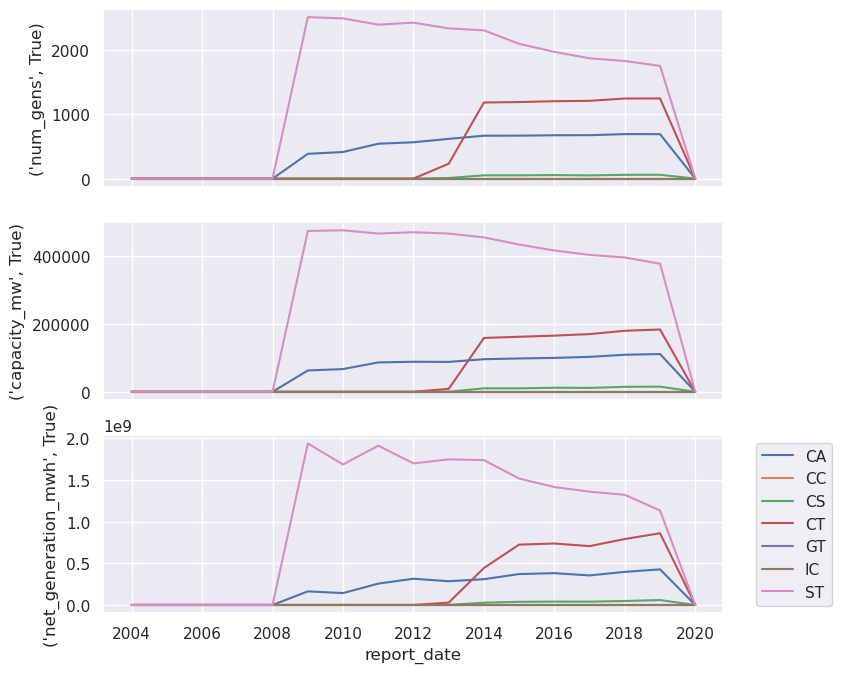

In [32]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(8,8))
sns.lineplot(x="report_date", y=("num_gens", True), data=unit_summary, hue="prime_mover_code", ax=axes[0], legend=False)
sns.lineplot(x="report_date", y=("capacity_mw", True), data=unit_summary, hue="prime_mover_code", ax=axes[1], legend=False)
sns.lineplot(x="report_date", y=("net_generation_mwh", True), data=unit_summary, hue="prime_mover_code", ax=axes[2])
plt.legend(loc="center left", bbox_to_anchor=(1.04, 0.5))
plt.show();

### Proportional Unit Coverage

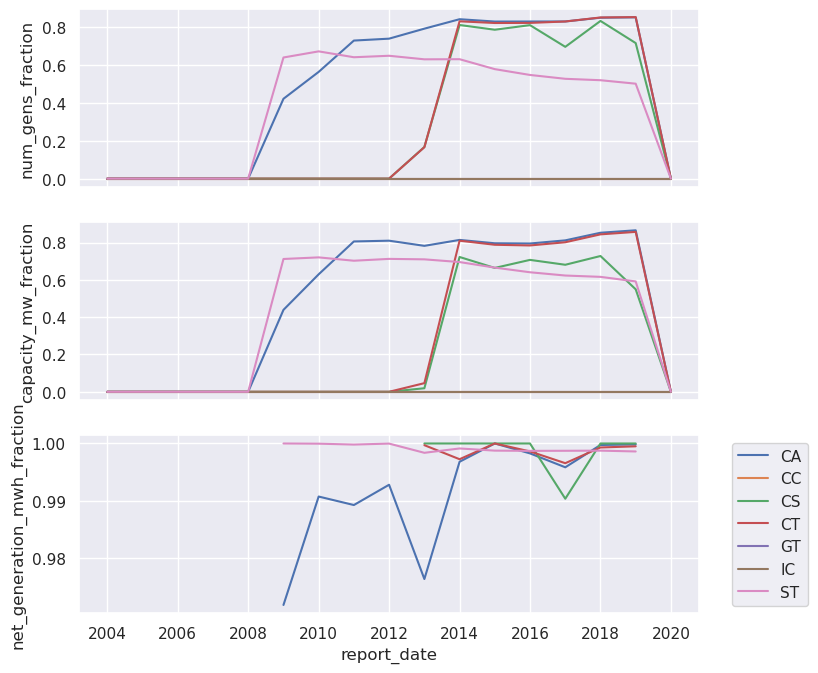

In [33]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(8,8))
sns.lineplot(x="report_date", y="num_gens_fraction", data=unit_summary, hue="prime_mover_code", ax=axes[0], legend=False)
sns.lineplot(x="report_date", y="capacity_mw_fraction", data=unit_summary, hue="prime_mover_code", ax=axes[1], legend=False)
sns.lineplot(x="report_date", y="net_generation_mwh_fraction", data=unit_summary, hue="prime_mover_code", ax=axes[2])
plt.legend(loc="center left", bbox_to_anchor=(1.04, 0.5))
plt.show();

# Questions to answer / tasks
* Does every boiler that we know of (in the boiler entity table) mapped to generators in the BGA table? Or are there some orphaned, unassociated boilers?
* Add new unit_id_pudl and origin flag into into generators_eia860 output table.

# Net Generation Allocation

In [ ]:
assert False

In [ ]:
gf_cols = [
    "plant_id_eia",
    "report_date",
    "energy_source_code",
    "prime_mover_code",
    "net_generation_mwh",
    "fuel_consumed_mmbtu_for_electricity",
]

gens_cols = [
    "plant_id_eia",
    "generator_id",
    "report_date",
    "energy_source_code_1",
    "energy_source_code_2",
    "energy_source_code_3",
    "energy_source_code_4",
    "energy_source_code_5",
    "energy_source_code_6",
    "capacity_mw",
    "prime_mover_code",
]

# Cull fully reported units
* In some plants, all of the generators report all of their fuel consumption and electricity generation in the `generation_eia923` and `boiler_fuel_eia923` tables. If they also don't have CHP, our current heat rate calculation should fully accommodate these plants already.
* In other plants, all of the electricity generation and fuel consumption being reported in association with a particular type of prime mover (but maybe not all prime movers) are fully covered by the more granular boiler / generator reporting, and so those plant-prime combinations can be removed from the heat rate calculations based on the `generation_fuel_eia923` table data. So long as there's no CHP. This is a more general case of the bullet above, so maybe we should just do this as the first cut.
* To identify these cases, we need to aggregate net generation and fuel consumption on the basis of `unit_id_pudl` and identify cases in which all generators of any prime mover type that is involved have been included in that aggregation, on an annual basis. In these cases the net generation and fuel consumption associated with those prime mover types can be safely removed from the `generation_fuel_eia923` table, leaving only fuel and electricity that hasn't been accounted for, or is only partially accounted for.

# Assess New Unit ID coverage
* Run the same assessment functions as we did above
* Per generator
* Per MW installed
* Per MWh of net generation

# Heat rates by Plant-Prime
* The `generation_fuel_eia923` table breaks down net generation & fuel consumption by plant and prime mover.
* Can one calculate realistic heat rates on the basis of plant-prime? Or do they always need to have units?
* Calculate the distribution of plant-prime heat rates and plot them to see what they look like.
* It seems likely that this strategy probably won't work, and we'll need to do some kind of grouping into pseudo-units.

In [ ]:
gen_fuel = pudl_out.gf_eia923()

In [ ]:
len(gen_fuel)

In [ ]:
assert False

# Combined Heat and Power
* What fraction of generators, capacity, and generation are associated with generators that also do CHP?

In [ ]:
gf_eia923 = pudl_out.gf_eia923()
gf_eia923["fuel_ratio"] = gf_eia923.fuel_consumed_for_electricity_mmbtu / gf_eia923.fuel_consumed_mmbtu
gf_eia923["no_chp"] = pd.Series(np.isclose(gf_eia923.fuel_ratio, 1.0))
plt.hist(gf_eia923.fuel_ratio, bins=20)
plt.yscale("log")
plt.xlabel("Fraction of fuel used for electricity")
plt.ylabel("Number of Records (log scale)");

In [ ]:
gf_eia923.groupby("report_date")[["fuel_consumed_for_electricity_mmbtu", "fuel_consumed_mmbtu"]].sum().plot()
plt.ylim(0,5e9)
plt.ylabel("Fuel Consumed [MMBTU]");

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(
    gf_eia923.fuel_consumed_mmbtu,
    gf_eia923.fuel_consumed_for_electricity_mmbtu,
    s=1, alpha=0.01, color="black",
)
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e3, 1e8)
plt.ylim(1e3, 1e8)
plt.xlabel("Total Fuel Consumed [MMBTU]")
plt.ylabel("Fuel Consumed for Electricity [MMBTU]");

In [ ]:
chp_summary = chp_prevalence(prepped_gens)
chp_summary

# Assess Existing Heat Rates
* We need some way to compare different ways of calculating heat rates and choose between them.
* We want to check both for their correctness, and their completeness.
* Apparent correctness will depend on the type of generator / unit type. Need to define different expectations.

In [ ]:
%%time
hr_by_unit = pudl_out.hr_by_unit()
hr_by_unit.info()

## Compile Net Generation
* **By generator**
  * `net_generation_mwh` available from `generation_eia923` table
  * Associated with `plant_id_eia` and `generator_id` columns directly.
  * Can be associated with `unit_id_pudl` if the generator is part of an identified unit
  * Can be associated with a `technology_description` and `prime_mover_code` based on the `generators_eia860` table.
  * Can be associated with a list of energy sources based on `energy_source_N` in `generators_eia860` table.
* **By plant-prime-fuel**
  * `net_generation_mwh` is available from generation_fuel_eia923`

## Compile Fuel Consumption
* **By boiler**
  * `total_heat_content_mmbtu` and `fuel_type_code_pudl` are available by `plant_id_eia` and `boiler_id` in `boiler_fuel_eia923`
  * This value can be be associated with a `unit_id_pudl` based on the BGA table.
  * The heat consumed in here includes fuels both for electricity and steam (direct heat) outputs.
* **By plant-prime-fuel**
  * Available in `generation_fuel` and broken down as for CHP vs Electricity separately.

## Identify Combined Cycle Units
* Combined Cycle turbines show up in the generators table, but have no "boiler" so they don't end up in the boiler-generator-association
* This means they don't get assigned `unit_id_pudl` values and are often lost.
* However, they are identifiable based on `technology_description` in the generators table, and so can be associated with a plant.
* Within a given plant, it's possible to combine all the natural gas that goes into a 

## Questions:
* Do all of the generators that show up in the generation table end up getting PUDL Unit IDs assigned?
* Where are the heat inputs being reported for combined cycle units? Do they really exist after 2015? What is still missing?
* Triage units / generators into: Easy, Hard, and Impossible. Work on Hard ones until diminishing returns. Assign impossible and too-hard ones the median values.

## Tables of Interest:
* `generation_eia923`
* `generation_fuel_eia923`
* `boiler_generator_assn_eia860`
* `generators_eia860`
* `generators_entity_eia`
* `boiler_fuel_eia923`

In [ ]:
gens_eia860_sql = """
SELECT report_date,
       plant_id_eia,
       generator_id,
       capacity_mw,
       energy_source_code_1,
       energy_source_code_2,
       energy_source_code_3,
       energy_source_code_4,
       energy_source_code_5,
       energy_source_code_6,
       fuel_type_code_pudl,
       technology_description,
FROM generators_eia860
"""

gens_entity_sql = """
SELECT report_date,
       plant_id_eia,
       generator_id,
       prime_mover_code,
       bypass_heat_recovery,
       associated_combined_heat_and_power,
FROM generators_entity_eia
"""

gen_eia923_sql = """
SELECT report_date,
       plant_id_eia,
       generator_id,
       net_generation_mwh
FROM generation_eia923
"""

gf_eia923_sql = """
SELECT report_date,
       plant_id_eia,
       nuclear_unit_id,
       fuel_type,
       fuel_type_code_pudl,
       prime_mover_code,
       fuel_consumed_mmbtu,
       fuel_consumed_for_electricity_mmbtu,
       net_generation_mwh
FROM generation_fuel_eia923
"""

bga_sql = """
SELECT report_date,
       plant_id_eia,
       unit_id_pudl,
       generator_id,
       boiler_id
FROM boiler_generator_assn_eia860
"""

bf_eia923_sql = """
SELECT report_date,
       plant_id_eia,
       boiler_id,
       fuel_type_code,
       fuel_type_code_pudl,
       fuel_consumed_units,
       fuel_mmbtu_per_unit
FROM boiler_fuel_eia923
"""


## Compile Fuel Consumption
  * Reported by boiler in `boiler_fuel_eia923` and so can be associated 

# Preliminary Data Wrangling
Once all of the data is loaded and looks like it's in good shape, do any initial wrangling that's specific to this particular analysis. This should mostly make use of the higher level functions which were defined above. If this step takes a while, don't be shy about producing `logging` outputs.

# Data Analysis and Visualization
* Now that you've got the required data in a usable form, you can tell the story of your analysis through a mix of visualizations, and further data wrangling steps.
* This narrative should be readable, with figures that have titles, legends, and labeled axes as appropriate so others can understand what you're showing them.
* The code should be concise and make use of the parameters and functions which you've defined above when possible. Functions should contain comprehensible chunks of work that make sense as one step in the story of the analysis.

In [ ]:
coal_ax = finite_distplot(mcoe_coal, "heat_rate_mmbtu_mwh", max_val=20)
plt.title("Coal heat rate distribution");

In [ ]:
gas_ax = finite_distplot(mcoe_gas, "heat_rate_mmbtu_mwh", max_val=20)
plt.title("Gas heat rate distribution");